In [72]:
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer

In [122]:
original = pd.read_csv('new_dataset/owid-covid-data-most-recent.csv')

df = pd.read_csv('multivariate.csv')
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] < '2024-01-14']
df = df.sort_values(by='date')

# impute missing values
# when total_cases is nan, set is to 0 
df['total_cases'] = df['total_cases'].fillna(0)
df['new_cases'] = df['new_cases'].fillna(0)
df['total_cases_per_million'] = df['total_cases_per_million'].fillna(0)
df['new_cases_per_million'] = df['new_cases_per_million'].fillna(0)
df = df.drop(columns = ['weekly_icu_admissions_per_million'], axis = 1, errors = 'ignore')
vaccine_columns = [col for col in df.columns if 'vaccin' in col]
# for the dates before december 11 2020, for the rows where the vaccine columns are nan, set them to 0
df.loc[df['date'] < '2020-12-13', vaccine_columns] = df.loc[df['date'] < '2020-12-13', vaccine_columns].fillna(0)
df = df.set_index('date')
df = df.dropna(subset=['new_deaths'])
df = pd.get_dummies(df)

train_size = int(len(df) * 0.75)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

X_train = train.drop(columns=['new_deaths'])
y_train = train['new_deaths']
X_test = test.drop(columns=['new_deaths'])
y_test = test['new_deaths']

# import randomized search


mase = MeanAbsoluteScaledError(sp=4)

#K-fold cross validation to find optimal parameters for XGBoost
param_grid = {'max_depth': [4,8],
              'learning_rate': [0.01, 0.1, .3, .4],
               'reg_lambda':[0, 5, 10],
                'n_estimators':[100, 500, 1000],
                'gamma': [0, 10, 100]}

cv = TimeSeriesSplit(n_splits=4)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_distributions = param_grid, n_iter = 50,
                             verbose = 2,
                             n_jobs=-1,
                             cv = cv,
                             scoring = 'neg_mean_absolute_error',
                             return_train_score=True,
                             )
optimal_params.fit(X_train,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross MAE = ",optimal_params.best_score_)

#Train XGBoost model with optimal parameters
model = xgb.XGBRegressor(max_depth=optimal_params.best_params_['max_depth'],
                        learning_rate=optimal_params.best_params_['learning_rate'],
                        reg_lambda=optimal_params.best_params_['reg_lambda'],
                        n_estimators=optimal_params.best_params_['n_estimators'],
                        gamma=optimal_params.best_params_['gamma'],
                        random_state=1,
                        early_stopping_rounds=100)
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          eval_metric='mae'
         )

Fitting 4 folds for each of 50 candidates, totalling 200 fits
[CV] END gamma=0, learning_rate=0.1, max_depth=4, n_estimators=100, reg_lambda=10; total time=   0.8s
[CV] END gamma=0, learning_rate=0.1, max_depth=8, n_estimators=100, reg_lambda=0; total time=   3.4s
[CV] END gamma=0, learning_rate=0.1, max_depth=4, n_estimators=100, reg_lambda=10; total time=   1.7s
[CV] END gamma=10, learning_rate=0.1, max_depth=8, n_estimators=100, reg_lambda=10; total time=   1.6s
[CV] END gamma=0, learning_rate=0.1, max_depth=8, n_estimators=100, reg_lambda=0; total time=   1.7s
[CV] END gamma=0, learning_rate=0.1, max_depth=4, n_estimators=100, reg_lambda=10; total time=   2.4s
[CV] END gamma=10, learning_rate=0.1, max_depth=8, n_estimators=100, reg_lambda=10; total time=   3.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=4, n_estimators=100, reg_lambda=10; total time=   3.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=8, n_estimators=100, reg_lambda=0; total time=   5.3s
[CV] END gamma=10, le

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, ...)

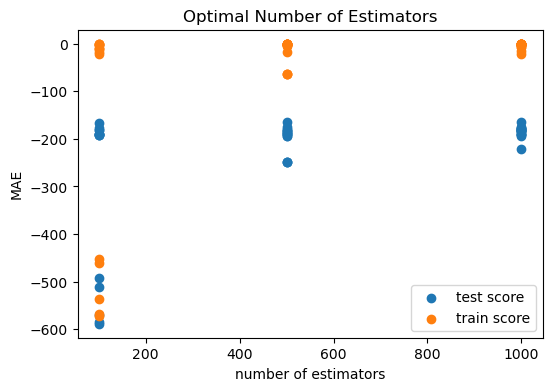

In [123]:
# visualize performance on the parameters grid
cv_results = pd.DataFrame(optimal_params.cv_results_)

plt.figure(figsize=(6,4))
plt.scatter(cv_results["param_n_estimators"], cv_results["mean_test_score"])
plt.scatter(cv_results["param_n_estimators"], cv_results["mean_train_score"])
plt.xlabel('number of estimators')
plt.ylabel('MAE')
plt.title("Optimal Number of Estimators")
plt.legend(['test score', 'train score'], loc='lower right')


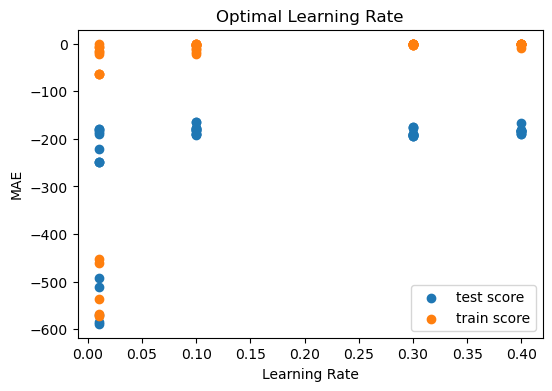

In [124]:
plt.figure(figsize=(6,4))
plt.scatter(cv_results["param_learning_rate"], cv_results["mean_test_score"])
plt.scatter(cv_results["param_learning_rate"], cv_results["mean_train_score"])
plt.xlabel('Learning Rate')
plt.ylabel('MAE')
plt.title("Optimal Learning Rate")
plt.legend(['test score', 'train score'], loc='lower right')



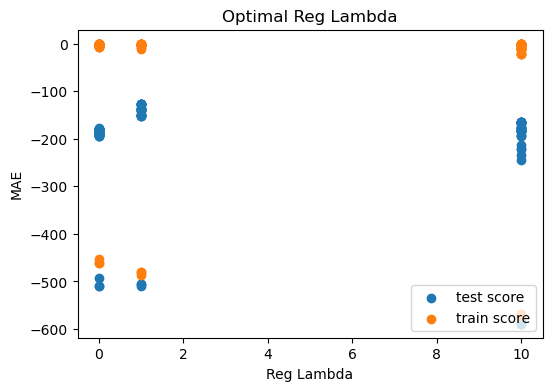

In [119]:
plt.figure(figsize=(6,4))
plt.scatter(cv_results["param_reg_lambda"], cv_results["mean_test_score"])
plt.scatter(cv_results["param_reg_lambda"], cv_results["mean_train_score"])
plt.xlabel('Reg Lambda')
plt.ylabel('MAE')
plt.title("Optimal Reg Lambda")
plt.legend(['test score', 'train score'], loc='lower right')



[0]	validation_0-mae:1001.76028	validation_1-mae:877.36582
[1]	validation_0-mae:905.07137	validation_1-mae:795.02182


[2]	validation_0-mae:818.41579	validation_1-mae:717.77967
[3]	validation_0-mae:740.96058	validation_1-mae:648.53194
[4]	validation_0-mae:672.15191	validation_1-mae:585.70755
[5]	validation_0-mae:608.95584	validation_1-mae:528.81696
[6]	validation_0-mae:551.29956	validation_1-mae:477.01754
[7]	validation_0-mae:500.53253	validation_1-mae:431.32677
[8]	validation_0-mae:453.61348	validation_1-mae:389.16423
[9]	validation_0-mae:411.15780	validation_1-mae:351.58828
[10]	validation_0-mae:373.42568	validation_1-mae:318.13408
[11]	validation_0-mae:340.32617	validation_1-mae:286.81746
[12]	validation_0-mae:308.23021	validation_1-mae:260.49897
[13]	validation_0-mae:280.37364	validation_1-mae:234.97176
[14]	validation_0-mae:255.29914	validation_1-mae:211.72324
[15]	validation_0-mae:232.97391	validation_1-mae:192.44794
[16]	validation_0-mae:211.21810	validation_1-mae:174.85842
[17]	validation_0-mae:192.65209	validation_1-mae:158.45739
[18]	validation_0-mae:176.19030	validation_1-mae:145.25188
[19]	

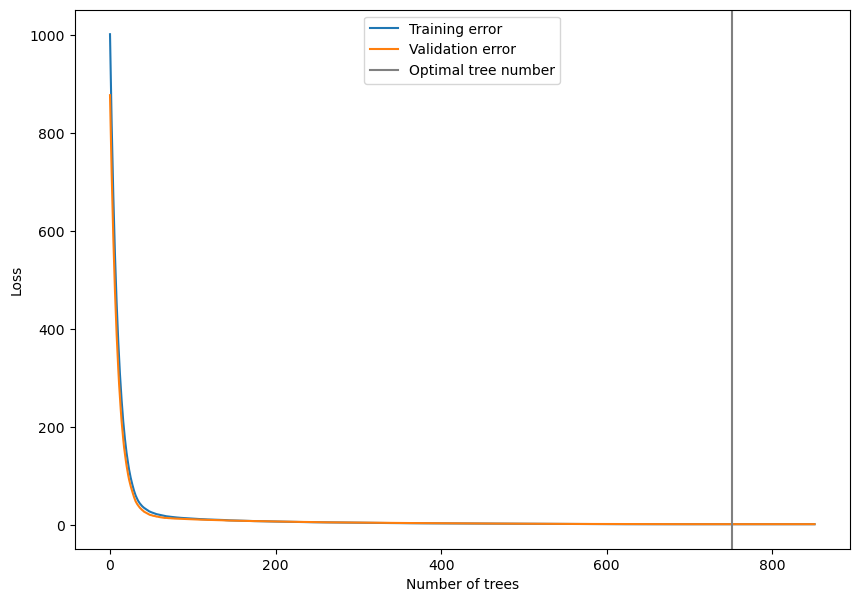

In [21]:
model = xgb.XGBRegressor(max_depth=optimal_params.best_params_['max_depth'],
                        learning_rate=optimal_params.best_params_['learning_rate'],
                        reg_lambda=optimal_params.best_params_['reg_lambda'],
                        n_estimators=optimal_params.best_params_['n_estimators'],
                        gamma=optimal_params.best_params_['gamma'],
                        subsample=optimal_params.best_params_['subsample'],
                        colsample_bytree=optimal_params.best_params_['colsample_bytree'],
                        random_state=1,
                        early_stopping_rounds=100,
                        eval_metric='mae')
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 45)

model.fit(X_train, y_train,
        eval_set=[(X_train_sub,y_train_sub),(X_test_sub, y_test_sub)],
        verbose=True)

results = model.evals_result()
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["mae"], label="Training error")
plt.plot(results["validation_1"]["mae"], label="Validation error")
plt.axvline(model.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()
# test['Prediction'] = model.predict(X_test)
# deaths = pd.concat([test, train], sort=False)
# _ = deaths[['new_deaths','Prediction']].plot(figsize=(15, 5))

[0]	validation_0-mae:819.04395	validation_1-mae:134.58670


[1]	validation_0-mae:621.69763	validation_1-mae:104.56468
[2]	validation_0-mae:472.74184	validation_1-mae:81.02513
[3]	validation_0-mae:359.71277	validation_1-mae:63.44959
[4]	validation_0-mae:274.85412	validation_1-mae:49.37845
[5]	validation_0-mae:210.27089	validation_1-mae:38.83802
[6]	validation_0-mae:161.27619	validation_1-mae:31.80785
[7]	validation_0-mae:123.59237	validation_1-mae:26.39680
[8]	validation_0-mae:95.27019	validation_1-mae:22.13440
[9]	validation_0-mae:73.63660	validation_1-mae:19.64822
[10]	validation_0-mae:57.38240	validation_1-mae:17.61085
[11]	validation_0-mae:45.13284	validation_1-mae:16.00279
[12]	validation_0-mae:35.98518	validation_1-mae:14.94018
[13]	validation_0-mae:28.85969	validation_1-mae:14.25394
[14]	validation_0-mae:23.61177	validation_1-mae:13.66487
[15]	validation_0-mae:19.93453	validation_1-mae:13.48360
[16]	validation_0-mae:17.10981	validation_1-mae:13.17953
[17]	validation_0-mae:15.03045	validation_1-mae:13.06565
[18]	validation_0-mae:13.35847	v

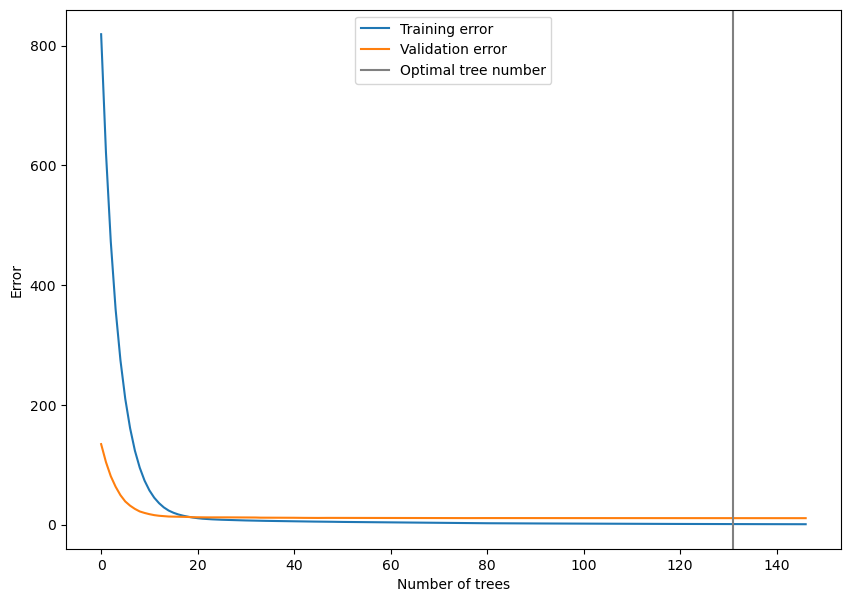

In [121]:
model = xgb.XGBRegressor(learning_rate=0.25, n_estimators=500, early_stopping_rounds=15)
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 45)

model.fit(X_train, y_train,
        eval_set=[(X_train,y_train),(X_test, y_test)],
        verbose=True,
        eval_metric='mae')
results = model.evals_result()
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["mae"], label="Training error")
plt.plot(results["validation_1"]["mae"], label="Validation error")
plt.axvline(model.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Error")
plt.legend()


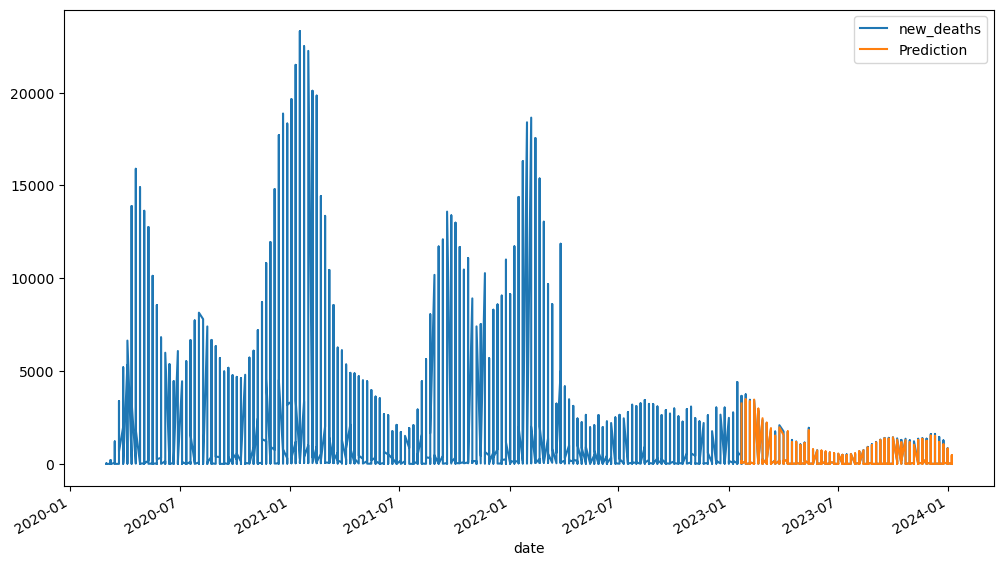

In [90]:
test['Prediction'] = model.predict(X_test)
deaths = pd.concat([test, train], sort=False)
_ = deaths[['new_deaths','Prediction']].plot(figsize=(12, 7))


In [87]:
df = df.dropna(subset=['new_deaths'])
test = test.dropna(subset=['new_deaths'])

In [95]:
y_true = test[['new_deaths']].copy()
y_true.sort_index(inplace=True)
y_pred = test['Prediction'].squeeze() 
y_pred.sort_index(inplace=True)
y_train_df = train[['new_deaths']].copy()
y_train_df.sort_index(inplace=True)
mase = MeanAbsoluteScaledError(sp=4)
mase = mase(y_true, y_pred, y_train = y_train_df)
mase

0.006095264287940925